# Burgers equation


## Problem setup


We will solve a Burgers equation:

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \nu\frac{\partial^2u}{\partial x^2}, \qquad x \in [-1, 1], \quad t \in [0, 1]
$$


with the Dirichlet boundary conditions and initial conditions

$$
u(-1,t)=u(1,t)=0, \quad u(x,0) = - \sin(\pi x).
$$

## Dimensional Analysis

### Step 1: Assign Dimensions to Variables

1. **Spatial Coordinate $x$:**
   - The dimension of $x$ is length:

     $$
     [x] = L.
     $$

2. **Time $t$:**
   - The dimension of time is:

     $$
     [t] = T.
     $$

3. **Velocity $u$:**
   - Velocity has dimensions of length per unit time:

     $$
     [u] = L / T.
     $$

4. **Viscosity $\nu$:**
   - The term $\nu \frac{\partial^2 u}{\partial x^2}$ involves the second spatial derivative of velocity, which must have the same dimensions as the time derivative $\frac{\partial u}{\partial t}$.

---

### Step 2: Analyze the Dimensions of Each Term

1. **Time Derivative Term:**
   - The time derivative $\frac{\partial u}{\partial t}$ has dimensions:

     $$
     \left[\frac{\partial u}{\partial t}\right] = \frac{[u]}{[t]} = \frac{L / T}{T} = \frac{L}{T^2}.
     $$

2. **Advection Term:**
   - The advection term $u \frac{\partial u}{\partial x}$ involves the spatial derivative of velocity:

     $$
     \left[u \frac{\partial u}{\partial x}\right] = [u] \cdot \frac{[u]}{[x]} = \frac{L}{T} \cdot \frac{L / T}{L} = \frac{L}{T^2}.
     $$

3. **Diffusion Term:**
   - The diffusion term $\nu \frac{\partial^2 u}{\partial x^2}$ involves the second spatial derivative of velocity:

     $$
     \left[\frac{\partial^2 u}{\partial x^2}\right] = \frac{[u]}{[x]^2} = \frac{L / T}{L^2} = \frac{1}{L T}.
    
     $$
   - Therefore, the diffusion term has dimensions:

     $$
     \left[\nu \frac{\partial^2 u}{\partial x^2}\right] = [\nu] \cdot \frac{1}{L T} = \frac{L}{T^2}.
     $$

---

### Step 3: Determine the Dimensions of $\nu$

- The diffusion term $\nu \frac{\partial^2 u}{\partial x^2}$ must have the same dimensions as the time derivative $\frac{\partial u}{\partial t}$:

  $$
  [\nu] \cdot \frac{1}{L T} = \frac{L}{T^2} \implies [\nu] = \frac{L^2}{T}.
  $$
- Therefore, the viscosity $\nu$ has dimensions of kinematic viscosity:

  $$
  [\nu] = \frac{L^2}{T}.
  $$

---

### Step 4: Summary of Dimensions

| Variable/Parameter     | Physical Meaning                   | Dimensions            |
|------------------------|-----------------------------------|-----------------------|
| $x$                   | Spatial coordinate                | $L$                 |
| $t$                   | Time                              | $T$                 |
| $u$                   | Velocity                          | $L / T$             |
| $\nu$                 | Kinematic viscosity               | $L^2 / T$           |

---

### Step 5: Initial and Boundary Conditions

1. **Boundary Conditions:**
   - The boundary conditions $u(-1,t) = u(1,t) = 0$ are given in meters per second:

     $$
     [u(-1,t)] = [u(1,t)] = L / T.
     $$

2. **Initial Condition:**
   - The initial condition $u(x,0) = -\sin(\pi x)$ is given in meters per second:
   
     $$
     [u(x,0)] = L / T.
     $$
   - The term $\sin(\pi x)$ is dimensionless because $x$ is in meters, and $\pi$ is a dimensionless constant.

## Implementation

This description goes through the implementation of a solver for the above described Burgers equation step-by-step.

First, import the libraries we need:

In [1]:
import brainstate as bst
import brainunit as u
import numpy as np
from deepxde import pinnx

We begin by defining a computational geometry and time domain. We can use a built-in class ``Interval`` and ``TimeDomain`` and we combine both the domains using ``GeometryXTime`` as follows:


In [2]:
geometry = pinnx.geometry.GeometryXTime(
    geometry=pinnx.geometry.Interval(-1., 1.),
    timedomain=pinnx.geometry.TimeDomain(0., 0.99)
).to_dict_point(x=u.meter, t=u.second)

Next, we express the PDE residual of the Burgers equation:

In [3]:
v = 0.01 / u.math.pi * u.meter ** 2 / u.second


def pde(x, y):
    jacobian = approximator.jacobian(x)
    hessian = approximator.hessian(x)
    dy_x = jacobian['y']['x']
    dy_t = jacobian['y']['t']
    dy_xx = hessian['y']['x']['x']
    residual = dy_t + y['y'] * dy_x - v * dy_xx
    return residual

Next, we consider the boundary/initial condition. ``on_boundary`` is chosen here to use the whole boundary of the computational domain in considered as the boundary condition. We include the ``geomtime`` space, time geometry created above and ``on_boundary`` as the BCs in the ``DirichletBC`` function of DeepXDE. We also define ``IC`` which is the inital condition for the burgers equation and we use the computational domain, initial function, and ``on_initial`` to specify the IC.


In [4]:
uy = u.meter / u.second

bc = pinnx.icbc.DirichletBC(lambda x: {'y': 0. * uy})
ic = pinnx.icbc.IC(lambda x: {'y': -u.math.sin(u.math.pi * x['x'] / u.meter) * uy})

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 20:


In [5]:
approximator = pinnx.nn.Model(
    pinnx.nn.DictToArray(x=u.meter, t=u.second),
    pinnx.nn.FNN(
        [geometry.dim] + [20] * 3 + [1],
        "tanh",
        bst.init.KaimingUniform()
    ),
    pinnx.nn.ArrayToDict(y=uy)
)

Now, we have specified the geometry, PDE residual, and boundary/initial condition. We then define the ``TimePDE`` problem as


In [6]:
problem = pinnx.problem.TimePDE(
    geometry,
    pde,
    [bc, ic],
    approximator,
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
)

The number 2540 is the number of training residual points sampled inside the domain, and the number 80 is the number of training points sampled on the boundary. We also include 160 initial residual points for the initial conditions.

Now, we have the PDE problem and the network. We build a ``Trainer`` and choose the optimizer and learning rate:


In [7]:
trainer = pinnx.Trainer(problem)
trainer.compile(bst.optim.Adam(1e-3)).train(iterations=15000)

Compiling trainer...
'compile' took 0.047883 s

Training trainer...

Step      Train loss                                                  Test loss                                                   Test metric
0         [0.15803409 * 10.0^0 * ((meter / second) / second) ** 2,    [0.15803409 * 10.0^0 * ((meter / second) / second) ** 2,    []    
           {'ibc0': {'y': 0.25960198 * meter / second}},               {'ibc0': {'y': 0.25960198 * meter / second}},                    
           {'ibc1': {'y': 1.1659584 * meter / second}}]                {'ibc1': {'y': 1.1659584 * meter / second}}]                     
1000      [0.04754296 * 10.0^0 * ((meter / second) / second) ** 2,    [0.04754296 * 10.0^0 * ((meter / second) / second) ** 2,    []    
           {'ibc0': {'y': 0.00308682 * meter / second}},               {'ibc0': {'y': 0.00308682 * meter / second}},                    
           {'ibc1': {'y': 0.06809452 * meter / second}}]               {'ibc1': {'y': 0.06809452 * meter

After we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss:


In [8]:
trainer.compile(bst.optim.LBFGS(1e-3)).train(2000, display_every=200)

Compiling trainer...
'compile' took 0.105205 s

Training trainer...

Step      Train loss                                                Test loss                                                 Test metric
15000     [0.002326 * 10.0^0 * ((meter / second) / second) ** 2,    [0.002326 * 10.0^0 * ((meter / second) / second) ** 2,    []    
           {'ibc0': {'y': 7.791486e-06 * meter / second}},           {'ibc0': {'y': 7.791486e-06 * meter / second}},                
           {'ibc1': {'y': 0.00277965 * meter / second}}]             {'ibc1': {'y': 0.00277965 * meter / second}}]                  
15200     [0.00468681 * 10.0^0 * ((meter / second) / second) ** 2,  [0.00468681 * 10.0^0 * ((meter / second) / second) ** 2,  []    
           {'ibc0': {'y': 6.556747e-06 * meter / second}},           {'ibc0': {'y': 6.556747e-06 * meter / second}},                
           {'ibc1': {'y': 0.00299743 * meter / second}}]             {'ibc1': {'y': 0.00299743 * meter / second}}]              

Let's visualize and save the data.

Saving loss history to D:\codes\projects\pinnx\docs\examples-pinn-forward\loss.dat ...
Saving checkpoint into D:\codes\projects\pinnx\docs\examples-pinn-forward\loss.dat
Saving training data to D:\codes\projects\pinnx\docs\examples-pinn-forward\train.dat ...
Saving checkpoint into D:\codes\projects\pinnx\docs\examples-pinn-forward\train.dat
Saving test data to D:\codes\projects\pinnx\docs\examples-pinn-forward\test.dat ...
Saving checkpoint into D:\codes\projects\pinnx\docs\examples-pinn-forward\test.dat


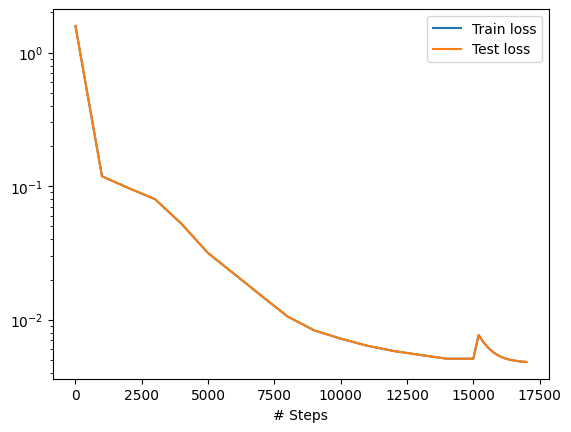

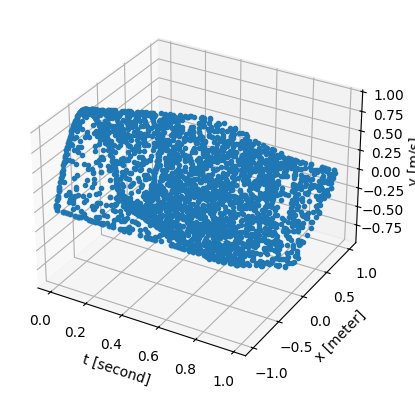

In [9]:
trainer.saveplot(issave=True, isplot=True)

We can also test the model with the data:

In [ ]:
def gen_testdata():
    data = np.load("../dataset/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = {'x': np.ravel(xx) * u.meter, 't': np.ravel(tt) * u.second}
    y = exact.flatten()[:, None]
    return X, y * uy

In [10]:
X, y_true = gen_testdata()
y_pred = trainer.predict(X)
f = pde(X, y_pred)
print("Mean residual:", u.math.mean(u.math.absolute(f)))
print("L2 relative error:", pinnx.metrics.l2_relative_error(y_true, y_pred['y']))

Mean residual: 0.02894243 * (meter / second) / second
L2 relative error: 224.70277
